## Imports and load data

In [15]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import os
from tensorflow.keras import *
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import classification_report

In [17]:
# load dataframe, delete article link column
pd.set_option('display.max_colwidth', None)
# there are v1 and v2
file_name = 'Sarcasm_Headlines_Dataset.json'
df = pd.read_json(file_name, lines=True)
del df['article_link']
df.head(5)

,headline,is_sarcastic
0,former versace store clerk sues over secret 'black code' for minority shoppers,0
1,"the 'roseanne' revival catches up to our thorny political mood, for better and worse",0
2,mom starting to fear son's web series closest thing she will have to grandchild,1
3,"boehner just wants wife to listen, not come up with alternative debt-reduction ideas",1
4,j.k. rowling wishes snape happy birthday in the most magical way,0


In [18]:
# split data into train and test set
train_df = df.sample(frac=0.8, random_state=0)
test_df = df.drop(train_df.index)

## Preprocessing

In [42]:
# preprocessing - tokenization
vocab_size = 1000
embedding_dim = 16
max_length = 100
trunc_type='post'
padding_type='post'
oov_token = "<OOV>"

x_train, y_train = train_df['headline'], train_df['is_sarcastic']
x_test, y_test = test_df['headline'], test_df['is_sarcastic']



tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_token)
tokenizer.fit_on_texts(x_train)
word_index = tokenizer.word_index

train_sequences = tokenizer.texts_to_sequences(x_train)
train_padded = pad_sequences(train_sequences, padding=padding_type, truncating=trunc_type, maxlen=max_length)

test_sequences = tokenizer.texts_to_sequences(x_test)
test_padded = pad_sequences(test_sequences, padding=padding_type, truncating=trunc_type, maxlen=max_length)

# Need this block to get it to work with TensorFlow 2.x
train_padded = np.array(train_padded)
test_padded = np.array(test_padded)
y_train = np.array(y_train)
# print(y_test)
y_test = np.array(y_test)
print(y_test)

[0 0 0 ... 1 0 1]


In [20]:
print(train_padded[0])

[ 539    1    5    1 1264 3957 1265   15 9259  129  435 5929    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0]


## Create and train model

In [21]:
# create a simple model
model = Sequential([
    layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    layers.GlobalAveragePooling1D(),
    layers.Dense(24, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])
optimizer = optimizers.Adam()
loss = losses.BinaryCrossentropy()
metrics=['accuracy']
model.compile(optimizer, loss, metrics)

In [22]:
# train
history = model.fit(train_padded, y_train, epochs=10, batch_size=64, validation_split=0.2)

Epoch 1/5
  1/268 [..............................] - ETA: 1:27 - loss: 0.6945 - accuracy: 0.4688

2022-02-16 13:00:22.125266: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


267/268 [============================>.] - ETA: 0s - loss: 0.6838 - accuracy: 0.5575

2022-02-16 13:00:30.204051: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


268/268 [==============================] - 9s 31ms/step - loss: 0.6837 - accuracy: 0.5575 - val_loss: 0.6727 - val_accuracy: 0.5674
Epoch 2/5
268/268 [==============================] - 8s 30ms/step - loss: 0.6258 - accuracy: 0.6205 - val_loss: 0.5432 - val_accuracy: 0.8119
Epoch 3/5
268/268 [==============================] - 8s 30ms/step - loss: 0.4360 - accuracy: 0.8412 - val_loss: 0.3873 - val_accuracy: 0.8472
Epoch 4/5
268/268 [==============================] - 8s 30ms/step - loss: 0.3226 - accuracy: 0.8791 - val_loss: 0.3474 - val_accuracy: 0.8503
Epoch 5/5
268/268 [==============================] - 8s 30ms/step - loss: 0.2722 - accuracy: 0.8972 - val_loss: 0.3259 - val_accuracy: 0.8594


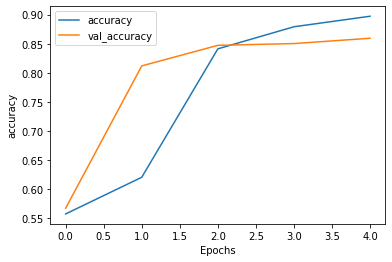

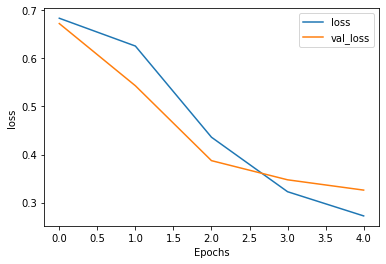

In [23]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_' + string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_' + string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

## Evaulate on test set

In [58]:
# loss and accuracy
loss, acc = model.evaluate(test_padded, y_test, batch_size=64, verbose=0)
print(f'Loss is: {loss} \nAcc is: {acc} \n')

# f1 score
y_pred = (model.predict(test_padded) > 0.5).astype("int32")
print(classification_report(y_test, y_pred))

Loss is: 0.3368736505508423 
Acc is: 0.8566080331802368 

              precision    recall  f1-score   support

           0       0.86      0.88      0.87      2982
           1       0.85      0.83      0.84      2360

    accuracy                           0.86      5342
   macro avg       0.86      0.85      0.85      5342
weighted avg       0.86      0.86      0.86      5342



## Predict sarcasm with new incoming sentences

In [62]:
# predict
sentences = ["It’s okay if you don’t like me. Not everyone has good taste.",
             "Today is a nice day."]
sequences = tokenizer.texts_to_sequences(sentences)
padded = pad_sequences(sequences, padding=padding_type, truncating=trunc_type, maxlen=max_length)
model.predict(padded)

array([[0.9483726 ],
       [0.05088653]], dtype=float32)